# Example 04 - Quantum annealing

In this example, we will study a case related to quantum computers, more precisely, adiabatic quantum computing. 
In this context, it is worth mentioning QUBO - Quadratic Unconstrained Binary Optimization. 
QUBO allows us to define various optimization problems, and the QUBO formalism can be easily converted into the Ising Hamiltonian, which is used for solving problems using quantum annealing. The QUBO cost function is given by:

$$
f(X) = \sum_{ij} Q_{ij} X_i X_j,
$$

where $X_i \in \{0, 1\}$ and $X_i^2 = X_i$. 
Please note that the formula can be divided into cases where $i = j$ and $i \neq j$. 
To solve the QUBO problem, we need to embed the problem into the matrix $Q_{ij}$ and find the solution $X_0$ that minimizes the given $f(X)$

$$
X_0 = \arg \min_X f(X)
$$

## Graph coloring

There are many problems that can be formulated using QUBO, and one of them is the classical graph coloring problem. 
This problem involves coloring a given graph $G(E, V)$ in such a way that connected vertices have distinct colors. 
The problem can be formulated using the following expression for $H_G$

$$
H_G = \sum_i \left( 1 - \sum_c X_{ic} \right)^2 + \sum_{\langle i, j \rangle} \sum_c X_{ic} X_{jc}.
$$

Here, the binary variable $X_{ic}$ equals 1 when vertex $i$ has color $c$ and 0 otherwise. 
The first part ensures that only one color $c$ is selected for a given vertex $i$, while the second part introduces a penalty when neighboring vertices share the same color $c$.
If there exists a solution with $k$ colors, then there is a corresponding configuration $X$ where the "energy" is $H_G = 0$. 
The QUBO formulation can be easily converted into the Ising language, resulting in the Ising Hamiltonian

$$
H_G^{\text{Ising}} = \sum_{\langle i, j \rangle} \sum_{c=1}^k S_{ic}^z S_{jc}^z + 2 \sum_{i=1}^n \sum_{c_1 < c_2} S_{ic_1}^z S_{ic_2}^z + \sum_{i=1}^{n} \left(k + \frac12 \deg(i)-2 \right) \sum_{c=1}^k S_{ic}^z + \frac14 k |E| + \left( 1 + \frac14 k(k-3) \right)n.
$$

In `pystrel`, we work with $\sigma$ operators instead of $S$ where $S = \frac{1}{2} \sigma$. 
Below, you can find the terms converted to the $\sigma$ operator notation

$$
H_G^{\text{Ising}} = \frac14\sum_{\langle i, j \rangle} \sum_{c=1}^k \sigma_{ic}^z \sigma_{jc}^z + \frac12 \sum_{i=1}^n \sum_{c_1 < c_2} \sigma_{ic_1}^z \sigma_{ic_2}^z + \frac12\sum_{i=1}^{n} \left(k + \frac12 \deg(i)-2 \right) \sum_{c=1}^k \sigma_{ic}^z + \frac14 k |E| + \left( 1 + \frac14 k(k-3) \right)n.
$$

In [1]:
import pystrel as ps
import numpy as np
import matplotlib.pyplot as plt
import time as sys_time
from datetime import timedelta
from IPython.display import clear_output

## Quantum annealing

In this section, we delve into the concept of quantum annealing, a fundamental technique in adiabatic quantum computing. 
Quantum annealing involves the gradual transformation of a quantum system from an initial "easy" Hamiltonian to a problem-specific Hamiltonian, allowing the system to settle into a state that represents a solution to the problem.

In the context of our problem, we combine the problem Hamiltonian $H_G$ with an initial "easy" Hamiltonian that represents a transverse field in the Ising model, oriented along the $x$-axis:

$$
H(\tau) = A(\tau) \sum_{i=1}^{nk} \Delta_i \sigma_i^x + B(\tau) H_G^{\text{Ising}},
$$

Here, $A(\tau) = 1 - \tau$ and $B(\tau) = \tau$, with $\tau$ denoting the dimensionless parameter that varies smoothly from 0 to 1 as the annealing process unfolds ($\tau = t / T$, where $t$ is time and $T$ is the total annealing time).

During the annealing process, the initial Hamiltonian is dominant at the start ($\tau = 0$), and the system is more likely to be found in the ground state of the "easy" Hamiltonian. As the annealing parameter increases ($\tau$ approaches 1), the problem Hamiltonian $H_G^{\text{Ising}}$ becomes more influential, guiding the system toward solutions that minimize the original optimization problem. 
The annealing schedule is crucial, as a slow and controlled evolution allows the system to avoid getting trapped in local energy minima and find the global minimum.

In practical terms, quantum annealing exploits the quantum nature of the system, leveraging effects like tunneling and quantum entanglement to explore a broader solution space than classical algorithms. By harnessing these quantum phenomena, quantum annealing holds promise for solving complex optimization problems more efficiently.

Keep in mind that the success of quantum annealing depends on various factors, including the specific problem formulation, the choice of annealing schedule, and the characteristics of the quantum hardware being used. As quantum technology continues to advance, quantum annealing is poised to play an increasingly significant role in addressing real-world optimization challenges.

Below, you can see a schematic representation of how the states can evolve during the annealing process:

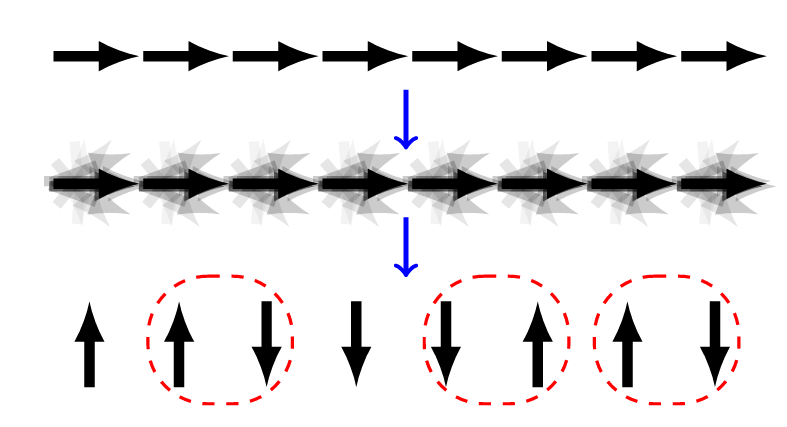

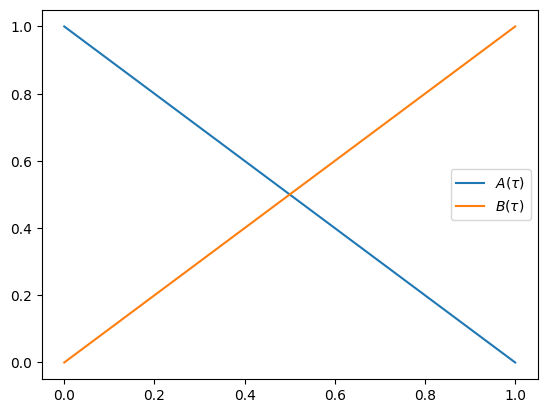

In [2]:
A = lambda tau: 1.0 - tau
B = lambda tau: tau

t = np.linspace(0, 1)
plt.plot(t, A(t), label=r"$A(\tau)$")
plt.plot(t, B(t), label=r"$B(\tau)$")
plt.legend()
plt.show()

Utilizing Python's list comprehension feature and properties from graph theory, implementing the terms becomes straightforward:

In [3]:
def generate_terms(graph, k, tau):
    n = graph.shape[0]
    E = graph.sum()
    deg = (graph + graph.T).sum(axis=1)
    L = n * k

    A = lambda tau: 1.0 - tau
    B = lambda tau: tau
    sx = lambda tau: { i: 2.0 * A(tau) for i in range(L) }
    sz = lambda tau: { i: v * B(tau) for i, v in enumerate(np.tile(0.5 * (k + 0.5 * deg - 2), (k, 1)).T.reshape(-1)) }
    sic1_sic2 = lambda tau: { (i * k + c1, i * k + c2): 0.5 * B(tau) for i in range(n) for c1 in range(k) for c2 in range(c1 + 1, k) }
    sic_sjc = lambda tau: { (i * k + c, j * k + c): 0.25 * B(tau) for i, j in np.ndindex(graph.shape) if graph[(i, j)] != 0 for c in range(k) }
    szsz = lambda tau: sic1_sic2(tau) | sic_sjc(tau)
    return { "hx": sx(tau), "Jz": szsz(tau), "hz": sz(tau) }

Below is the implementation of the "constant" term. 
While this part can be ignored in optimization or dynamics, it is considered in our calculations to recover the original stated problem in QUBO. 
This step can be helpful to check if our solution satisfies the condition $H=0$.

In [4]:
def const(graph, k):
    n = graph.shape[0]
    E = graph.sum()
    return 0.25 * k * E + (1 + 0.25 * k * (k - 3)) * n

In this example, we have considered the following graph topology (with $k=3$ available colors):

```
  1
 / | 
0--2
 \ |
  3
```

The graph below, with a color set {🔴, 🟢, 🔵}, exhibits 6 degenerate solutions:

```
   🔵      🟢       🔵      🔴       🟢      🔴    
  / |      / |      / |      / |      / |      / |     
🔴-🟢   🔴-🔵   🟢-🔴   🟢-🔵   🔵-🔴   🔵-🟢   
  \ |      \ |      \ |      \ |      \ |      \ |   
   🔵      🟢       🔵      🔴       🟢      🔴   
```

Below, we set `k` to 3 colors, encode the graph in a matrix `graph`, and represent all 6 `solutions` in binary format:

In [10]:
k = 3
graph = np.array([
    [0, 1, 1, 1],
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [0, 0, 0, 0],
])
solutions = [
    "100 010 001 010",
    "100 001 010 001",
    "010 001 100 001",
    "010 100 001 100",
    "001 010 100 010",
    "001 100 010 100",
]

First, we examined the spectrum of the final Hamiltonian (at $\tau=1$).
If our code works correctly, one should observe 6 degenerate states with an eigenenergy of $E=0$.

In [11]:
model = ps.Model({ "terms": generate_terms(graph, k, tau=1.0) })
h = model.build_hamiltonian(sparsity="dense", dtype=np.float64)
h += const(graph, k) * np.eye(model.sectors.size)
e, v = ps.spectrum.get_partial_spectrum(h, k=10)
e

array([-4.16198317e-15, -3.92974527e-15, -1.85830590e-15, -7.32483938e-16,
       -2.37270518e-16,  4.12772011e-15,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00])

Furthermore, it is possible to convert all `solutions` ($\textbf{S}$) into Hilbert basis states and project them onto all degenerate groundstates ($\textbf{gs}$):

$$
\sum_{i \in \textbf{S}} \sum_{n \in \textbf{gs}} |\langle n | i \rangle|^2,
$$

As a result, this quantity should equal **6**.

In [12]:
base = [model.build_base_state(i.replace(" ", "")) for i in solutions]
sum(ps.project(i, j) for i in base for j in v[:6])

6.000000000000003

Below is the complete solution for studying the described model.
To measure adiabaticity, we evaluate the projection of the final state $|\psi(T)\rangle$ onto all degenerate groundstates:

$$
    F = \sum_{i \in \textbf{gs}} |\langle i | \psi(T)\rangle|^2.
$$

In [13]:
def simulation(k: int, graph: np.ndarray, solutions: list, **kwargs):
    sparsity = kwargs.get("sparsity", "dense")
    device = kwargs.get("device", "cpu")
    T = kwargs.get("T", 10.0)
    dt = kwargs.get("dt", 0.01)

    model = ps.Model({"terms": generate_terms(graph, k, tau=0.0)})
    C = const(graph, k) * np.eye(model.sectors.size)

    def build_hamiltonian(time):
        model.update_terms(generate_terms(graph, k, tau=time / T))
        return model.build_hamiltonian(device=device, sparsity=sparsity) + C

    def ground_state(time):
        print("finding ground state...")
        h = build_hamiltonian(time)
        _, v = ps.spectrum.get_partial_spectrum(h, k=10)
        return v[0].astype(np.complex128)

    def measure_time(time, clear_time, start_time):
        current_sys_time = sys_time.time()
        if current_sys_time - clear_time > 0.5:
            clear_output(wait=True)
            prct = np.round(time / T * 100, 2)
            elapsed_time = timedelta(seconds=sys_time.time() - start_time)
            remaining_time = (100 - prct) / (prct + 1e-9) * elapsed_time
            print(
                f"{prct}% (elapsed time: {elapsed_time}, remaining time: {remaining_time})"
            )
            clear_time = current_sys_time
        return clear_time

    def propagate(psi):
        start_time = sys_time.time()
        clear_time = 0.0
        t = 0.0
        while t < T:
            psi = ps.propagate(psi, build_hamiltonian, t, dt, method="rk4")
            clear_time = measure_time(t, clear_time, start_time)
            t += dt
        return psi

    def project_solutions(psi):
        solution_base = [model.build_base_state(i.replace(" ", "")) for i in solutions]
        proj = 0.0
        for b in solution_base:
            proj += ps.project(psi, b)
        return proj

    psi = ground_state(time=0.0)
    psi = propagate(psi)

    return T, project_solutions(psi)

In [15]:
results = []

In [16]:
results.append(r := simulation(k, graph, solutions, T=.10))
print(r)

100.0% (elapsed time: 0:01:28.028106, remaining time: 0:00:00)
(0.1, 0.0015154379267959595)


In [12]:
results.append(r := simulation(k, graph, solutions, T=.20))
print(r)

95.0% (elapsed time: 0:02:48.907451, remaining time: 0:00:08.889866)
(0.2, 0.0016900865804426728)


In [13]:
results.append(r := simulation(k, graph, solutions, T=.50))
print(r)

98.0% (elapsed time: 0:06:46.253881, remaining time: 0:00:08.290896)
(0.5, 0.0032193819096692326)


In [14]:
results.append(r := simulation(k, graph, solutions, T=1.0))
print(r)

99.0% (elapsed time: 0:13:41.389661, remaining time: 0:00:08.296865)
(1.0, 0.011682741374071494)


In [15]:
results.append(r := simulation(k, graph, solutions, T=2.0))
print(r)

99.5% (elapsed time: 0:27:39.683855, remaining time: 0:00:08.340120)
(2.0, 0.021814505391223614)


In [16]:
results.append(r := simulation(k, graph, solutions, T=5.0))
print(r)

100.0% (elapsed time: 1:06:17.661055, remaining time: 0:00:00)
(5.0, 0.058656795103347356)


In [17]:
results.append(r := simulation(k, graph, solutions, T=10.0))
print(r)

100.0% (elapsed time: 2:12:00.757222, remaining time: 0:00:00)
(10.0, 0.1379780304711611)


In [18]:
results.append(r := simulation(k, graph, solutions, T=20.0))
print(r)

99.95% (elapsed time: 4:02:43.524248, remaining time: 0:00:07.285405)
(20.0, 0.33850717235267214)


In [12]:
results.append(r := simulation(k, graph, solutions, T=50.0))
print(r)

100.0% (elapsed time: 10:38:29.037026, remaining time: 0:00:00)
(50.0, 0.7863395777011377)


In [17]:
results.append(r := simulation(k, graph, solutions, T=100.0))
print(r)

99.99% (elapsed time: 21:21:01.987631, remaining time: 0:00:07.686967)
(100.0, 0.9433565983094909)


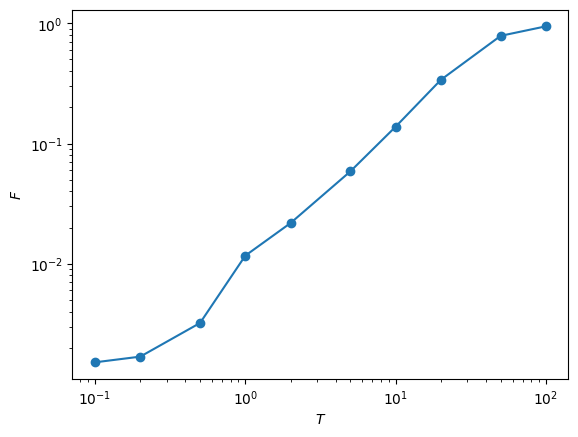

In [24]:
xy = np.array(results)

plt.xlabel("$T$")
plt.ylabel("$F$")
plt.plot(xy[:, 0], xy[:, 1], '-o')
plt.loglog()
plt.show()